In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

In [4]:
geography_path = "/kaggle/input/data-flow/geography.csv"
product_path = "/kaggle/input/data-flow/product.csv"
test_path = "/kaggle/input/data-flow/test.csv"
train_path = "/kaggle/input/data-flow/train.csv"

In [5]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_geo = pd.read_csv(geography_path)
df_product = pd.read_csv(product_path)

In [6]:
df_test = df_test.dropna()
df_train = df_train.dropna()
df_test

,ProductID,Date,Zip,Units,Revenue,COGS
0,1989,2022-06-01,54082,12,65764.44,65159.407152
1,582,2022-03-22,30012,14,59967.18,44705.532690
2,1828,2021-09-11,11377,15,51965.55,46665.063900
3,582,2022-06-01,55128,12,51400.44,38319.028020
4,415,2021-10-11,32174,29,333409.23,312271.084818
...,...,...,...,...,...,...
74677,794,2021-04-09,80602,1,1070.37,1092.312585
74678,794,2021-02-13,80915,1,1070.37,1092.312585
74679,793,2021-08-17,16038,1,1070.37,680.113098
74680,793,2021-02-13,80915,1,1070.37,680.113098


In [7]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.sort_values(by='Date')

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test.sort_values(by='Date')

In [8]:
df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

In [9]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

df_train = df_train.merge(df_geo, on="Zip", how="left")
df_train = df_train.merge(df_product, on="ProductID", how="left")
df_test = df_test.merge(df_geo, on="Zip", how="left")
df_test = df_test.merge(df_product, on="ProductID", how="left")

df_train

,Date,ProductID,Zip,Units,Revenue,COGS,City,State,Region,District,Category,Segment,Product
0,2010-07-04,631,50801,1,4280.85,4393.864440,"Creston, IA",IA,Central,District #30,Urban,Convenience,Maximus UC-96
1,2010-07-04,1041,11777,1,11651.85,5941.278315,"Port Jefferson, NY",NY,East,District #03,Urban,Convenience,Palma UC-13
2,2010-07-04,1484,15025,1,849.24,900.279324,"Clairton, PA",PA,East,District #13,Rural,Productivity,Quibus RP-76
3,2010-07-04,396,94566,1,10769.85,9854.412750,"Pleasanton, CA",CA,West,District #36,Urban,Moderation,Maximus UM-01
4,2010-07-04,396,27614,1,10706.85,9796.767750,"Raleigh, NC",NC,East,District #08,Urban,Moderation,Maximus UM-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
901556,2020-12-30,1588,45315,1,4062.87,2920.797243,"Clayton, OH",OH,East,District #16,Rural,Select,Quibus RS-26
901557,2020-12-30,449,27249,1,12473.37,11164.913487,"Gibsonville, NC",NC,East,District #08,Urban,Moderation,Maximus UM-54
901558,2020-12-30,651,28210,1,9890.37,5630.587641,"Charlotte, NC",NC,East,District #11,Urban,Convenience,Maximus UC-16
901559,2020-12-30,908,95120,2,5164.74,4886.876988,"San Jose, CA",CA,West,District #36,Urban,Extreme,Natura UE-17


In [10]:
df_train_pivot = df_train.pivot_table(index='Date', columns='ProductID', values='Units', aggfunc='sum').fillna(0)
df_test_pivot = df_test.pivot_table(index='Date', columns='ProductID', values='Units', aggfunc='sum').fillna(0)

In [11]:
revenue_train = df_train.groupby('Date')['Revenue'].sum()
units_train = df_train.groupby('Date')['Units'].sum()
revenue_train

Date
2010-07-04    1765391.67
2010-07-05    1425986.10
2010-07-06     302463.00
2010-07-07    1047787.65
2010-07-08     771811.74
                 ...    
2020-12-27    1091568.87
2020-12-28     998180.19
2020-12-29    1309889.70
2020-12-30    2194138.80
2020-12-31      16694.37
Name: Revenue, Length: 3718, dtype: float64

In [12]:
df_train_pivot = df_train_pivot.reindex(revenue_train.index).fillna(0)

In [17]:
revenue_train = revenue_train[-365:]
units_train = units_train[-365:]
exog_train = df_train_pivot[-365:]

In [25]:
# Dữ liệu test từ tập test có sẵn
revenue_test = df_test.groupby('Date')['Revenue'].sum()
units_test = df_test.groupby('Date')['Units'].sum()
exog_test = df_test_pivot

# Đảm bảo exog_train và exog_test có cùng số cột
all_columns = exog_train.columns.union(exog_test.columns)
exog_train = exog_train.reindex(columns=all_columns, fill_value=0)
exog_test = exog_test.reindex(columns=all_columns, fill_value=0)

In [19]:
# Kiểm định tính dừng bằng ADF Test
revenue_adf_test = adfuller(revenue_train)
print('Revenue:\n')
print(f'ADF Statistic: {revenue_adf_test[0]}')
print(f'p-value: {revenue_adf_test[1]}')
print(f'Critical Values: {revenue_adf_test[4]}')

units_adf_test = adfuller(units_train)
print('\nUnits:\n')
print(f'ADF Statistic: {units_adf_test[0]}')
print(f'p-value: {units_adf_test[1]}')
print(f'Critical Values: {units_adf_test[4]}')

Revenue:

ADF Statistic: -2.7941118681922723
p-value: 0.059119780669936645
Critical Values: {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}

Units:

ADF Statistic: -2.8047449005308467
p-value: 0.05759918281646698
Critical Values: {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}



ADF Test after Differencing:
ADF Statistic: -9.910071124958565
p-value: 3.186421415472799e-17
Critical Values: {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}


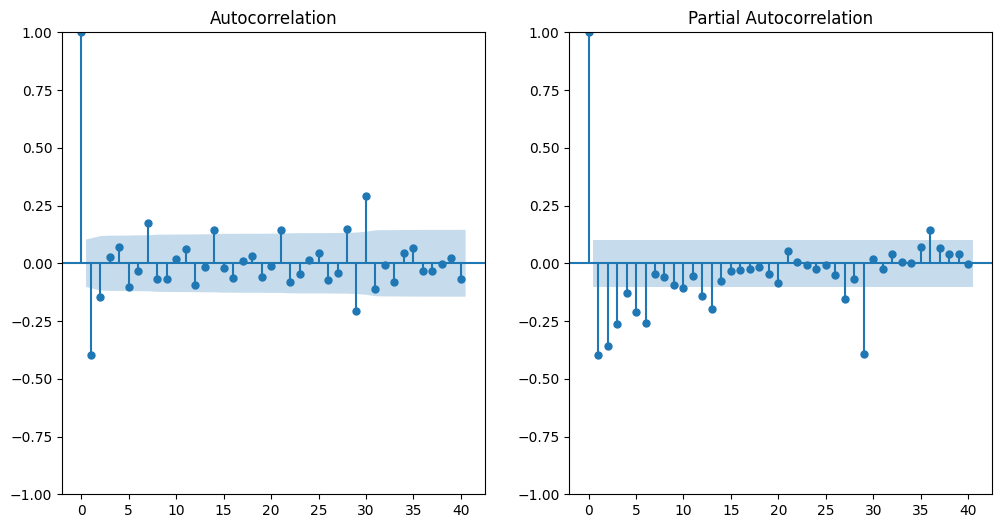


ADF Test after Differencing:
ADF Statistic: -10.604763318678463
p-value: 6.042501446411119e-19
Critical Values: {'1%': -3.44911857009962, '5%': -2.8698097654570507, '10%': -2.5711757061225153}


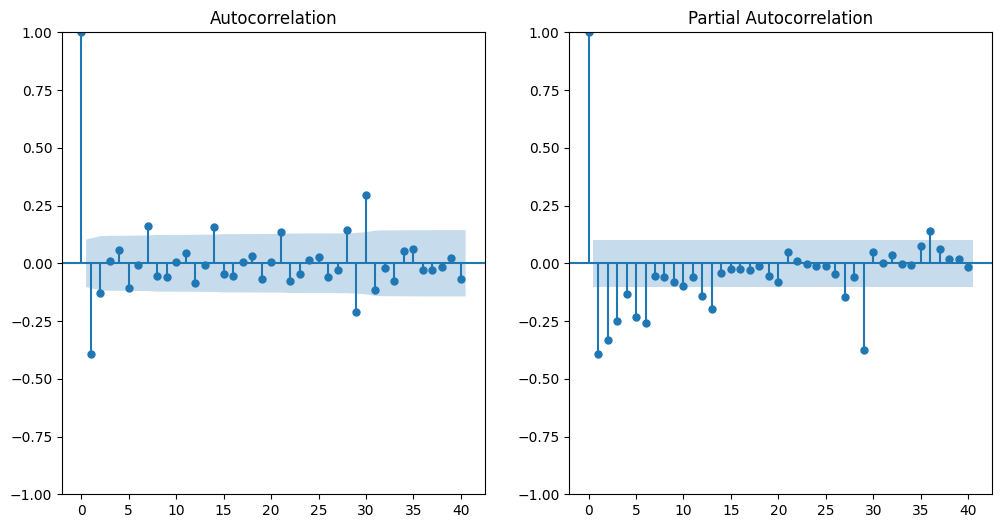

In [20]:
def check_stationarity_and_plot(revenue_train):
    adf_test = adfuller(revenue_train)
    
    if adf_test[1] > 0.05:
        revenue_diff = revenue_train.diff().dropna()
        adf_test_diff = adfuller(revenue_diff)
        print("\nADF Test after Differencing:")
        print(f'ADF Statistic: {adf_test_diff[0]}')
        print(f'p-value: {adf_test_diff[1]}')
        print(f'Critical Values: {adf_test_diff[4]}')
        
        # Vẽ ACF và PACF sau khi lấy sai phân
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plot_acf(revenue_diff, ax=plt.gca(), lags=40)
        plt.subplot(1, 2, 2)
        plot_pacf(revenue_diff, ax=plt.gca(), lags=40)
        plt.show()
    else:
        # Vẽ ACF và PACF nếu chuỗi đã dừng
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plot_acf(revenue_train, ax=plt.gca(), lags=40)
        plt.subplot(1, 2, 2)
        plot_pacf(revenue_train, ax=plt.gca(), lags=40)
        plt.show()

check_stationarity_and_plot(revenue_train)
check_stationarity_and_plot(units_train)

In [21]:
# Find optimize (p, d, q) using auto_arima
revenue_auto_model = auto_arima(revenue_train, exogenous=df_train_pivot, seasonal=True, m=7, stepwise=True, trace=True)
units_auto_model = auto_arima(units_train, exogenous=df_train_pivot, seasonal=True, m=7, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=11046.062, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11257.052, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11184.565, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11060.091, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11255.053, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=11053.821, Time=0.53 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=11052.432, Time=0.52 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=11045.248, Time=1.34 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=11046.444, Time=0.80 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=11045.290, Time=1.54 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=11046.053, Time=0.58 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=11043.762, Time=0.90 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=11043.905, Time=0.53 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=11045.212, Time=0.71 sec
 ARIMA(1,1,2)(2,0,2

In [23]:
# training progress
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

revenue_model = SARIMAX(
    revenue_train, exog=exog_train,
    order=revenue_auto_model.order, seasonal_order=revenue_auto_model.seasonal_order,
    enforce_stationarity=False, enforce_invertibility=False
)

with tqdm(total=100, desc="Training ARIMA-revenue model") as pbar:
    class Callback:
        def __call__(self, xk):
            pbar.update(1)
    revenue_result = revenue_model.fit(callback=Callback())

units_model = SARIMAX(
    units_train, exog=exog_train,
    order=units_auto_model.order, seasonal_order=units_auto_model.seasonal_order,
    enforce_stationarity=False, enforce_invertibility=False
)

with tqdm(total=100, desc="Training ARIMA-units model") as pbar:
    class Callback:
        def __call__(self, xk):
            pbar.update(1)
    units_result = units_model.fit(callback=Callback())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
Training ARIMA-revenue model:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Training ARIMA-revenue model:   0%|          | 0/100 [01:43<?, ?it/s]
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no 

In [27]:
revenue_forecast = revenue_result.forecast(steps=len(revenue_test), exog=exog_test)
units_forecast = units_result.forecast(steps=len(units_test), exog=exog_test)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
# Evaluation
def evaluate_model(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} Evaluation:")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("------------------------------------")

evaluate_model(revenue_test, revenue_forecast, "Revenue")
evaluate_model(units_test, units_forecast, "Units")

Revenue Evaluation:
R²: 0.8749
MAPE: 0.1888
RMSE: 355275.5572
------------------------------------
Units Evaluation:
R²: 0.9292
MAPE: 0.1494
RMSE: 33.8797
------------------------------------


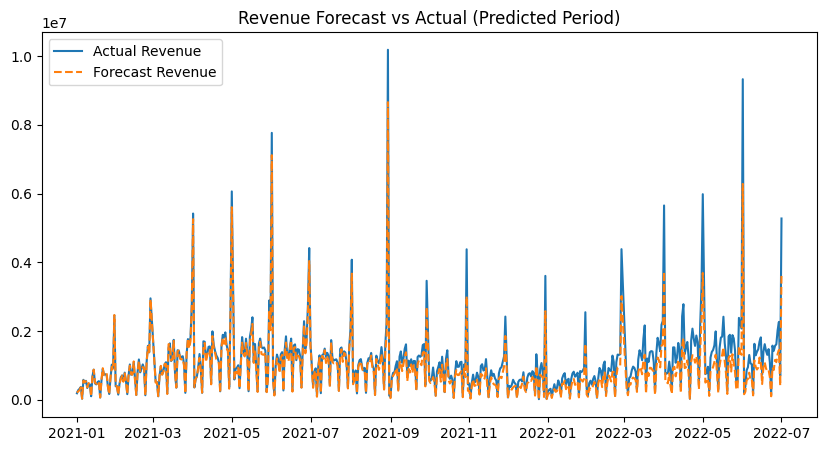

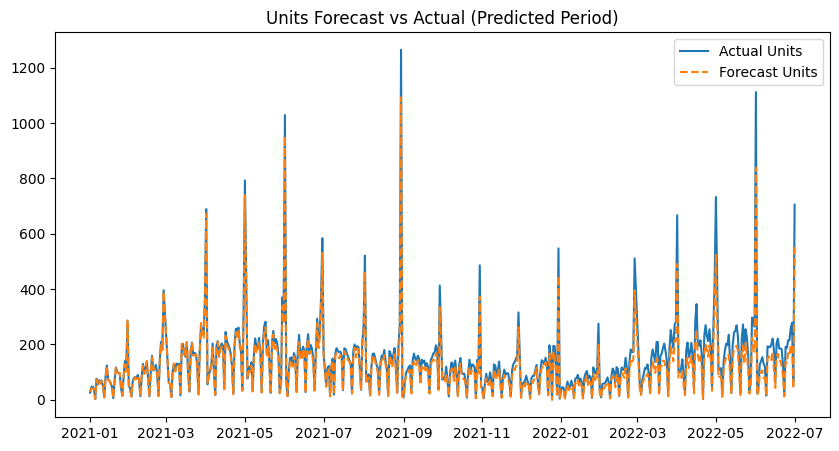

In [32]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(revenue_test.index, revenue_test, label="Actual Revenue", linestyle='solid')
plt.plot(revenue_test.index, revenue_forecast, label="Forecast Revenue", linestyle='dashed')
plt.legend()
plt.title("Revenue Forecast vs Actual (Predicted Period)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(units_test.index, units_test, label="Actual Units", linestyle='solid')
plt.plot(units_test.index, units_forecast, label="Forecast Units", linestyle='dashed')
plt.legend()
plt.title("Units Forecast vs Actual (Predicted Period)")
plt.show()